### III. Regression Analysis

In [1]:
pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [96]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

precip_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/precipitation-annual-tre.csv"
correct_temp_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/average-mean-surface-air.csv"
oni_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/Monthly%20Oceanic%20Nino%20Index%20(ONI)%20-%20Wide.csv"
copper_price_path = "https://raw.githubusercontent.com/YananZhang963/Final-Project/main/Daily%20Copper%20Price.xlsx"

#### IIIA: Data Cleaning

In [97]:
def read_and_clean_climate_data(file_path, value_name):
    raw = pd.read_csv(file_path, sep=';', header=None)
    df = raw.copy().iloc[1:]
    df.columns = ['Year', 'CodeValue']
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Value'] = df['CodeValue'].astype(str).str.split(',').str[-1]
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df[['Year', 'Value']].dropna()
    df = df.rename(columns={'Value': value_name})
    return df

correct_precip_df = pd.read_csv(precip_path)
precip_clean = correct_precip_df[['Year', 'Annual Precipitation']].rename(
    columns={'Annual Precipitation': 'Precipitation'}
).dropna()
correct_precip_df

,Year,Annual Precipitation,Trend 1951-2020,Trend 1971-2020,Trend 1991-2020
0,1950,1599.28,NaN,NaN,NaN
1,1951,1620.59,1451.140487,NaN,NaN
2,1952,1308.84,1452.423359,NaN,NaN
3,1953,1626.74,1453.706231,NaN,NaN
4,1954,1660.37,1454.989103,NaN,NaN
...,...,...,...,...,...
69,2019,1451.85,1538.375784,1520.840746,1520.718194
70,2020,1486.43,1539.658656,1520.932165,1521.175591
71,2021,1297.33,NaN,NaN,NaN
72,2022,1414.47,NaN,NaN,NaN


In [99]:
# Clean copper price (daily to annual)
copper_df = pd.read_excel(copper_price_path, engine="openpyxl")
date_col = copper_df['Date']
is_numeric = pd.to_numeric(date_col, errors='coerce').notnull()

copper_df['Parsed_Date'] = pd.NaT
copper_df.loc[is_numeric, 'Parsed_Date'] = pd.to_datetime(
    copper_df.loc[is_numeric, 'Date'].astype(float), origin='1899-12-30', unit='D')
copper_df.loc[~is_numeric, 'Parsed_Date'] = pd.to_datetime(
    copper_df.loc[~is_numeric, 'Date'], errors='coerce')

copper_df['Year'] = copper_df['Parsed_Date'].dt.year
annual_copper = copper_df.groupby('Year')['Value'].mean().reset_index()
annual_copper = annual_copper.rename(columns={'Value': 'Copper_Price'})
annual_copper

# Clean ONI data to annual mean
oni_df = pd.read_csv(oni_path)
oni_df['Year'] = pd.to_numeric(oni_df['Year'], errors='coerce')
oni_df = oni_df.dropna(subset=['Year'])
oni_df['Year'] = oni_df['Year'].astype(int)
oni_df_numeric = oni_df.drop(columns=['Year']).apply(pd.to_numeric, errors='coerce')
oni_df['ONI'] = oni_df_numeric.mean(axis=1)
oni_annual = oni_df[['Year', 'ONI']]

oni_annual

# Load correct temperature dataset
correct_temp_df = pd.read_csv(correct_temp_path)
correct_temp_clean = correct_temp_df[['Year', 'Annual Average Mean Surface Air Temperature']]
correct_temp_clean = correct_temp_clean.rename(columns={
    'Annual Average Mean Surface Air Temperature': 'Temperature'
})
correct_temp_clean = correct_temp_clean.dropna()
correct_temp_clean

# Merge all climate datasets
df_fully_corrected = annual_copper.merge(precip_clean, on='Year', how='inner')
df_fully_corrected = df_fully_corrected.merge(correct_temp_clean, on='Year', how='inner')
df_fully_corrected = df_fully_corrected.merge(oni_annual, on='Year', how='inner')
df_corrected_sorted = df_fully_corrected.sort_values('Year')
df_corrected_sorted

# Clean and prepare industrial datasets about copper (supply and demand)
cop_industry = pd.read_excel('CopperProductionDemand.xlsx', skiprows = 4)
cop_industry.head()
cop_industry

# Get clean datasets for World Production and Consumption
consum_prod = cop_industry[['Year', 'Consumption', 'World production']]
consum_prod

# Merge all datasets
alldata = pd.merge(df_corrected_sorted, consum_prod, on='Year', how='inner')
alldata

,Year,Copper_Price,Precipitation,Temperature,ONI,Consumption,World production
0,1959,0.310739,1449.99,8.30,0.050000,1330000.0,3430000.0
1,1960,0.298338,1330.97,8.77,-0.025000,1230000.0,3940000.0
2,1961,0.298112,1560.66,8.67,-0.066667,1330000.0,4090000.0
3,1962,0.292455,1190.10,8.86,-0.241667,1450000.0,4220000.0
4,1963,0.297616,1453.56,8.49,0.550000,1580000.0,4290000.0
5,1964,0.403233,1289.65,8.40,-0.366667,1660000.0,4450000.0
6,1965,0.489251,1578.89,8.35,0.766667,1820000.0,4660000.0
7,1966,0.633821,1291.67,8.29,0.341667,2140000.0,4580000.0
8,1967,0.491840,1389.65,8.21,-0.325000,1760000.0,4630000.0
9,1968,0.507980,1352.13,8.65,0.033333,1710000.0,5010000.0


#### IIIB: Exploratory Visualization of Each Variable Over Time

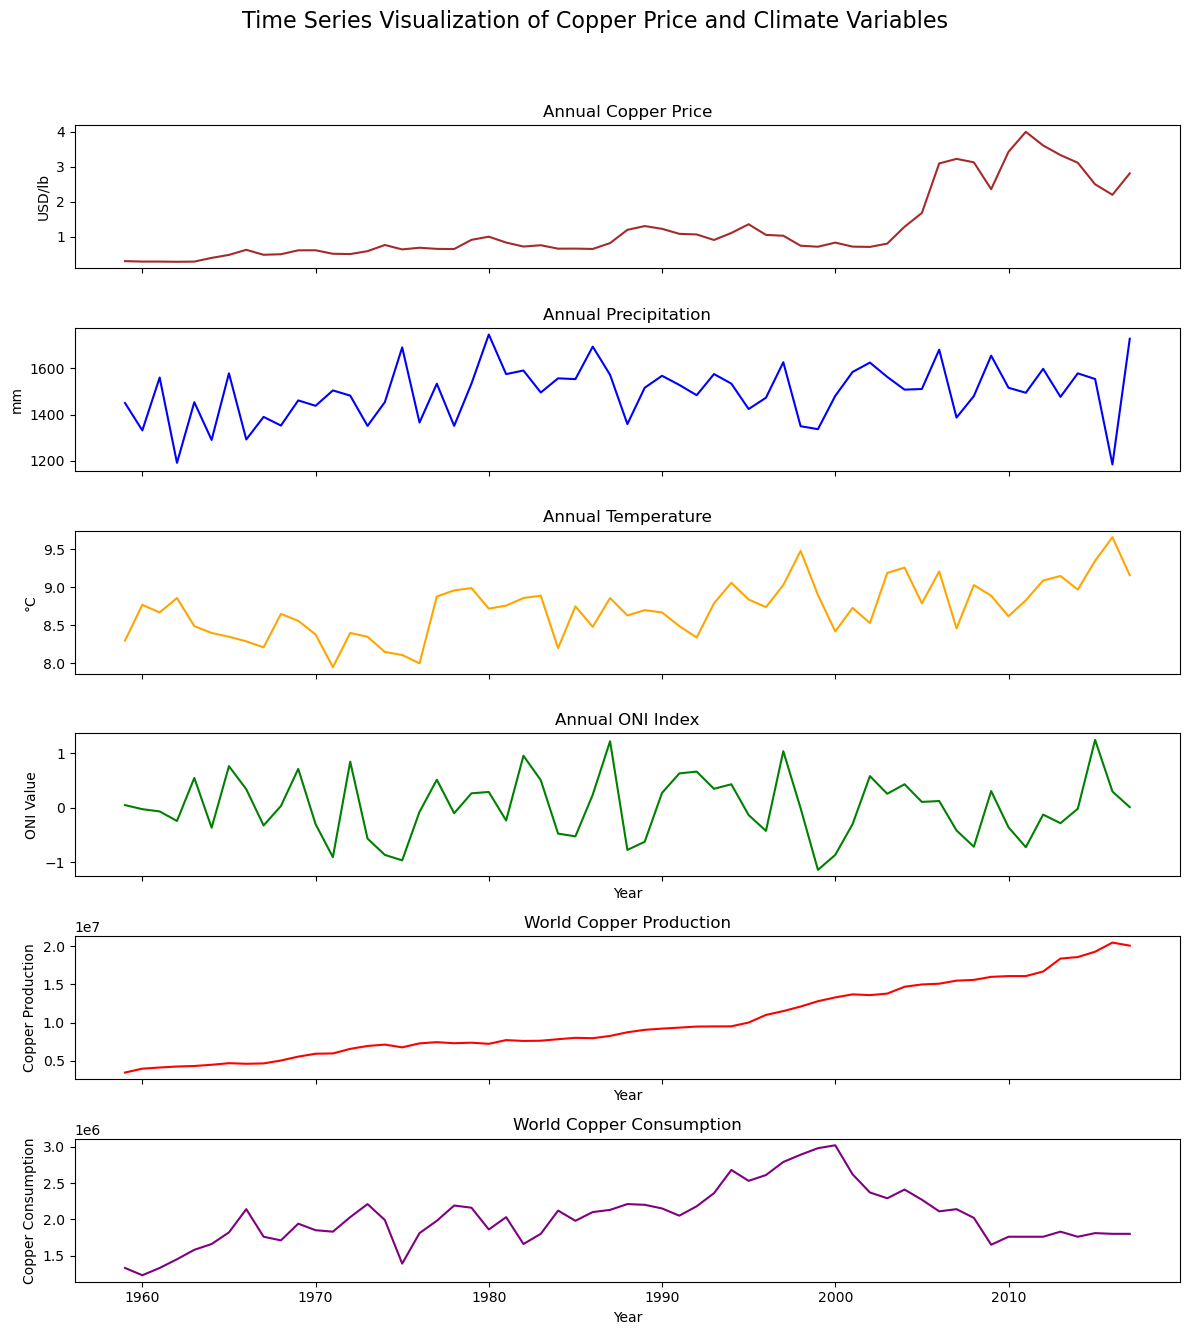

In [100]:
# Time Series Plots for Each Variable Separately
fig, axes = plt.subplots(6, 1, figsize=(12, 14), sharex=True)
fig.suptitle('Time Series Visualization of Copper Price and Climate Variables', fontsize=16)

# Copper Price
axes[0].plot(df_corrected_sorted['Year'], df_corrected_sorted['Copper_Price'], color='brown')
axes[0].set_title('Annual Copper Price')
axes[0].set_ylabel('USD/lb')

# Precipitation
axes[1].plot(df_corrected_sorted['Year'], df_corrected_sorted['Precipitation'], color='blue')
axes[1].set_title('Annual Precipitation')
axes[1].set_ylabel('mm')

# Temperature
axes[2].plot(df_corrected_sorted['Year'], df_corrected_sorted['Temperature'], color='orange')
axes[2].set_title('Annual Temperature')
axes[2].set_ylabel('°C')

# ONI Index
axes[3].plot(df_corrected_sorted['Year'], df_corrected_sorted['ONI'], color='green')
axes[3].set_title('Annual ONI Index')
axes[3].set_ylabel('ONI Value')
axes[3].set_xlabel('Year')

# World Copper Production
axes[4].plot(alldata['Year'], alldata['World production'], color='red')
axes[4].set_title('World Copper Production')
axes[4].set_ylabel('Copper Production')
axes[4].set_xlabel('Year')

# World Copper Demand
axes[5].plot(alldata['Year'], alldata['Consumption'], color='purple')
axes[5].set_title('World Copper Consumption')
axes[5].set_ylabel('Copper Consumption')
axes[5].set_xlabel('Year')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Insights got from this visualization:
These visualizations clearly demonstrate how climate and market variables evolve over time. Notably, any apparent correlations (or lack thereof) between these variables and copper prices may point toward underlying mechanisms influencing market behavior.  

One thing which we should be cautious about is these variables' noticeable upward trends over time, particularly for variables such as Copper Price, World Copper Production, and Temperature. Such concurrent upward movements imply that these variables may be influenced by common underlying long-term factors, such as global economic growth or climate change. Consequently, simple correlation or regression analyses might misleadingly suggest strong relationships merely because the variables share similar long-term growth trends, rather than because they have genuine causal or explanatory relationships. That's why we want to also involve some detrending analysis later in this section.

#### IIIC: Raw Regression Analysis

##### Correlation Matrix of all variables:

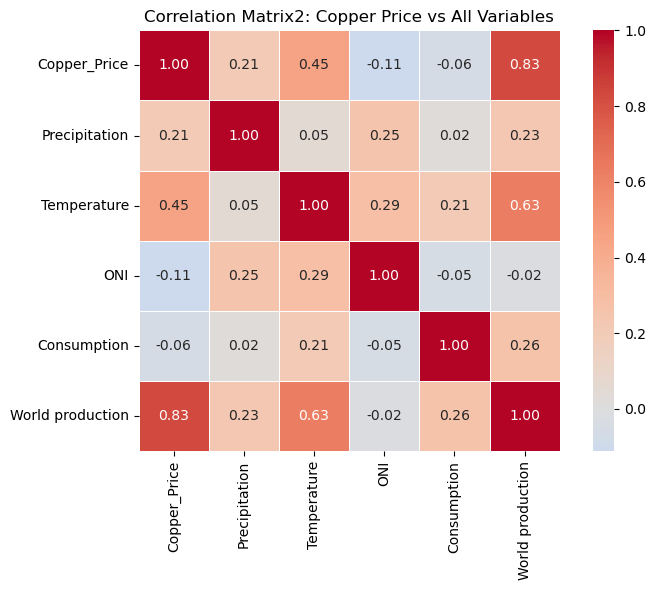

,Copper_Price,Precipitation,Temperature,ONI,Consumption,World production
Copper_Price,1.000000,0.210334,0.446756,-0.111790,-0.057025,0.826324
Precipitation,0.210334,1.000000,0.053673,0.254832,0.020329,0.231651
Temperature,0.446756,0.053673,1.000000,0.285612,0.212542,0.626955
ONI,-0.111790,0.254832,0.285612,1.000000,-0.050061,-0.017767
Consumption,-0.057025,0.020329,0.212542,-0.050061,1.000000,0.263727
World production,0.826324,0.231651,0.626955,-0.017767,0.263727,1.000000


In [101]:
corr_matrix2 = alldata[['Copper_Price', 'Precipitation', 'Temperature', 'ONI', 'Consumption', 'World production']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5, square=True)
plt.title('Correlation Matrix2: Copper Price vs All Variables')
plt.tight_layout()
plt.show()
corr_matrix2

# Some Insights got from this result:
1. Strong correlation between Copper Price and World Production could indicate demand-driven market behavior: increased demand leads to both higher production and higher prices.

2. Moderate correlation between Copper Price and Temperature suggests climatic variables may have indirect impacts on market conditions, such as production efficiency or regional supply disruptions.

3. Weak correlations between Copper Price and ONI & Precipitation suggest limited direct explanatory power from these climate factors in isolation.

4. Weak correlation with Consumption highlights the complexity of market pricing mechanisms where simple supply-demand relationships might be masked by external economic conditions or speculative trading behaviors.

These introductory exploration gave rise to the necessity of looking at these relationship more closely using regression model so that we can see the exact effect of each of these variables and their statistical significance.

##### Raw 1: Copper price on climate variables

In [102]:
X_all = df_corrected_sorted[['Precipitation', 'Temperature', 'ONI']]
X_all = sm.add_constant(X_all)
y_all = df_corrected_sorted['Copper_Price']
model_all = sm.OLS(y_all, X_all).fit()
print("\n--- Regression: Copper Price ~ Precip + Temp + ONI ---")
print(model_all.summary())


--- Regression: Copper Price ~ Precip + Temp + ONI ---
                            OLS Regression Results                            
Dep. Variable:           Copper_Price   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     8.957
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           6.31e-05
Time:                        01:06:20   Log-Likelihood:                -71.476
No. Observations:                  59   AIC:                             151.0
Df Residuals:                      55   BIC:                             159.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### Raw 2: World Copper Production on Climate variables in Chile

In [103]:
X_climate = alldata[['Precipitation', 'Temperature', 'ONI']]
X_climate = sm.add_constant(X_climate)
y_prod = alldata['World production']
model3 = sm.OLS(y_prod, X_climate).fit()
print("\n--- Regression: Copper Production ~ Precip + Temp + ONI---")
print(model3.summary())


--- Regression: Copper Production ~ Precip + Temp + ONI---
                            OLS Regression Results                            
Dep. Variable:       World production   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     18.46
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           2.07e-08
Time:                        01:06:23   Log-Likelihood:                -969.32
No. Observations:                  59   AIC:                             1947.
Df Residuals:                      55   BIC:                             1955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

##### Raw 3: Copper Demand on Climate Variables

In [104]:
y_demand = alldata['Consumption']
model4 = sm.OLS(y_demand, X_climate).fit()
print("\n--- Regression: Copper Demand ~ Precip + Temp + ONI---")
print(model4.summary())


--- Regression: Copper Demand ~ Precip + Temp + ONI---
                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.171
Date:                Tue, 08 Jul 2025   Prob (F-statistic):              0.329
Time:                        01:06:26   Log-Likelihood:                -842.14
No. Observations:                  59   AIC:                             1692.
Df Residuals:                      55   BIC:                             1701.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

##### Raw 4: Copper price on all variables (including both climate and industrial variables)

In [105]:
X_all2 = alldata[['Precipitation', 'Temperature', 'ONI', 'Consumption', 'World production']]
X_all2 = sm.add_constant(X_all2)
y_all2 = alldata['Copper_Price']
model_all2 = sm.OLS(y_all2, X_all2).fit()
print("\n--- Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production---")
print(model_all2.summary())


--- Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production---
                            OLS Regression Results                            
Dep. Variable:           Copper_Price   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     37.23
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           3.50e-16
Time:                        01:06:29   Log-Likelihood:                -38.763
No. Observations:                  59   AIC:                             89.53
Df Residuals:                      53   BIC:                             102.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

##### Visualize the regression relationship between copper production and each climate variable

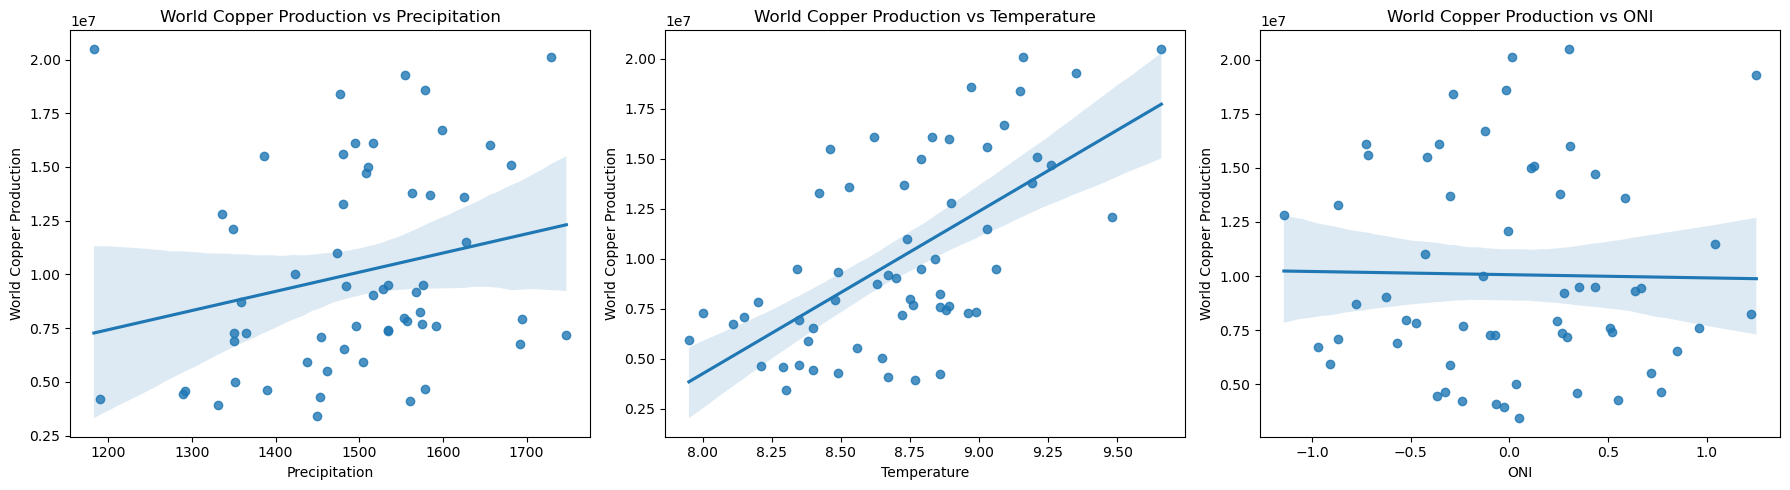

In [106]:
variables = ['Precipitation', 'Temperature', 'ONI']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, var in enumerate(variables):
    sns.regplot(x=var, y='World production', data=alldata, ax=axes[idx])
    axes[idx].set_title(f'World Copper Production vs {var}')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('World Copper Production')
plt.tight_layout()
plt.show()

##### General Summary and Interpretation of Raw Regression Results:

Our regression analyses on the raw data revealed several intuitive and expected relationships—for example, copper prices and copper production appear positively linked with climatic factors such as temperature and precipitation. However, we found something counterintuitive and interesting that warrants further exploration:

Counterintuitive Insight:

Notably, the Oceanic Niño Index (ONI), representing El Niño events, consistently showed a significant negative association with both copper prices and copper production. Intuitively, one might expect El Niño-related climate disruptions to constrain supply and push prices upward, but instead, we see the opposite effect.

Possible Interpretation:

This unexpected negative relationship could suggest more complex underlying mechanisms. For instance, El Niño events might be simultaneously causing global economic slowdowns or shifts in industrial activity that outweigh any immediate supply constraints, thus ultimately reducing copper prices and production. Alternatively, the observed negative relationships might simply reflect coincidental long-term economic or climatic trends rather than true causal interactions.

Connection to Detrending Analysis:

Because of these surprising results, and also because of the noticeable upward trends we observed on some variables in the exploratory visualization, we recognize a crucial possibility: the relationships we observed may be influenced or exaggerated by shared long-term trends (such as steady global economic growth or long-term climatic changes). To verify that the relationships we identify are meaningful, and not merely artifacts of common trends, it becomes essential to perform a detrending analysis.

Through detrending, we remove these overarching trends, enabling us to determine if these counterintuitive findings truly reflect causal or explanatory relationships rather than coincidental correlations due to simultaneous long-term trends. This will help us clarify the real underlying mechanisms that drive copper markets and climate interactions.

#### IIID: Detrending Analysis

In [107]:
from scipy.signal import detrend
# Step 1: Detrend the variables
detrended_data = alldata.copy()
variables_to_detrend = ['Copper_Price', 'Precipitation', 'Temperature', 'ONI', 'World production', 'Consumption']

In [ ]:
for var in variables_to_detrend:
    detrended_data[f'{var}_detrended'] = detrend(detrended_data[var].values)

##### Detrended 1: Copper Price on climate variables

In [109]:
X_detrend_climate = detrended_data[['Precipitation_detrended', 'Temperature_detrended', 'ONI_detrended']]
X_detrend_climate = sm.add_constant(X_detrend_climate)
y_detrend_copper_price = detrended_data['Copper_Price_detrended']
model_detrend1 = sm.OLS(y_detrend_copper_price, X_detrend_climate).fit()
print("\n--- Detrended Regression: Copper Price ~ Precip + Temp + ONI ---")
print(model_detrend1.summary())


--- Detrended Regression: Copper Price ~ Precip + Temp + ONI ---
                              OLS Regression Results                              
Dep. Variable:     Copper_Price_detrended   R-squared:                       0.034
Model:                                OLS   Adj. R-squared:                 -0.019
Method:                     Least Squares   F-statistic:                    0.6368
Date:                    Tue, 08 Jul 2025   Prob (F-statistic):              0.595
Time:                            01:14:27   Log-Likelihood:                -52.689
No. Observations:                      59   AIC:                             113.4
Df Residuals:                          55   BIC:                             121.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------

##### Detrended 2: World Copper Production on Climate variables in Chile

In [110]:
y_detrend_production = detrended_data['World production_detrended']
model_detrend2 = sm.OLS(y_detrend_production, X_detrend_climate).fit()
print("\n--- Detrended Regression: Copper Production ~ Precip + Temp + ONI ---")
print(model_detrend2.summary())


--- Detrended Regression: Copper Production ~ Precip + Temp + ONI ---
                                OLS Regression Results                                
Dep. Variable:     World production_detrended   R-squared:                       0.089
Model:                                    OLS   Adj. R-squared:                  0.039
Method:                         Least Squares   F-statistic:                     1.785
Date:                        Tue, 08 Jul 2025   Prob (F-statistic):              0.161
Time:                                01:15:39   Log-Likelihood:                -901.84
No. Observations:                          59   AIC:                             1812.
Df Residuals:                              55   BIC:                             1820.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                              coef    std err          t   

##### Detrended 3: Demand on Climate Variables

In [112]:
y_detrend_demand = detrended_data['Consumption_detrended']
model_detrend3 = sm.OLS(y_detrend_demand, X_detrend_climate).fit()
print("\n--- Detrended Regression: Copper Demand ~ Precip + Temp + ONI ---")
print(model_detrend3.summary())


--- Detrended Regression: Copper Demand ~ Precip + Temp + ONI ---
                              OLS Regression Results                             
Dep. Variable:     Consumption_detrended   R-squared:                       0.016
Model:                               OLS   Adj. R-squared:                 -0.038
Method:                    Least Squares   F-statistic:                    0.3006
Date:                   Tue, 08 Jul 2025   Prob (F-statistic):              0.825
Time:                           01:16:23   Log-Likelihood:                -838.58
No. Observations:                     59   AIC:                             1685.
Df Residuals:                         55   BIC:                             1693.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------

##### Detrended 4: Copper Price on All variables

In [113]:
X_detrend_all = detrended_data[['Precipitation_detrended', 'Temperature_detrended', 'ONI_detrended',
                               'Consumption_detrended', 'World production_detrended']]
X_detrend_all = sm.add_constant(X_detrend_all)
model_detrend4 = sm.OLS(y_detrend_copper_price, X_detrend_all).fit()
print("\n--- Detrended Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production ---")
print(model_detrend4.summary())


--- Detrended Regression: Copper Price ~ Precip + Temp + ONI + Consumption + Production ---
                              OLS Regression Results                              
Dep. Variable:     Copper_Price_detrended   R-squared:                       0.493
Model:                                OLS   Adj. R-squared:                  0.445
Method:                     Least Squares   F-statistic:                     10.29
Date:                    Tue, 08 Jul 2025   Prob (F-statistic):           6.24e-07
Time:                            01:17:09   Log-Likelihood:                -33.680
No. Observations:                      59   AIC:                             79.36
Df Residuals:                          53   BIC:                             91.82
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [

##### Detrended Visualization

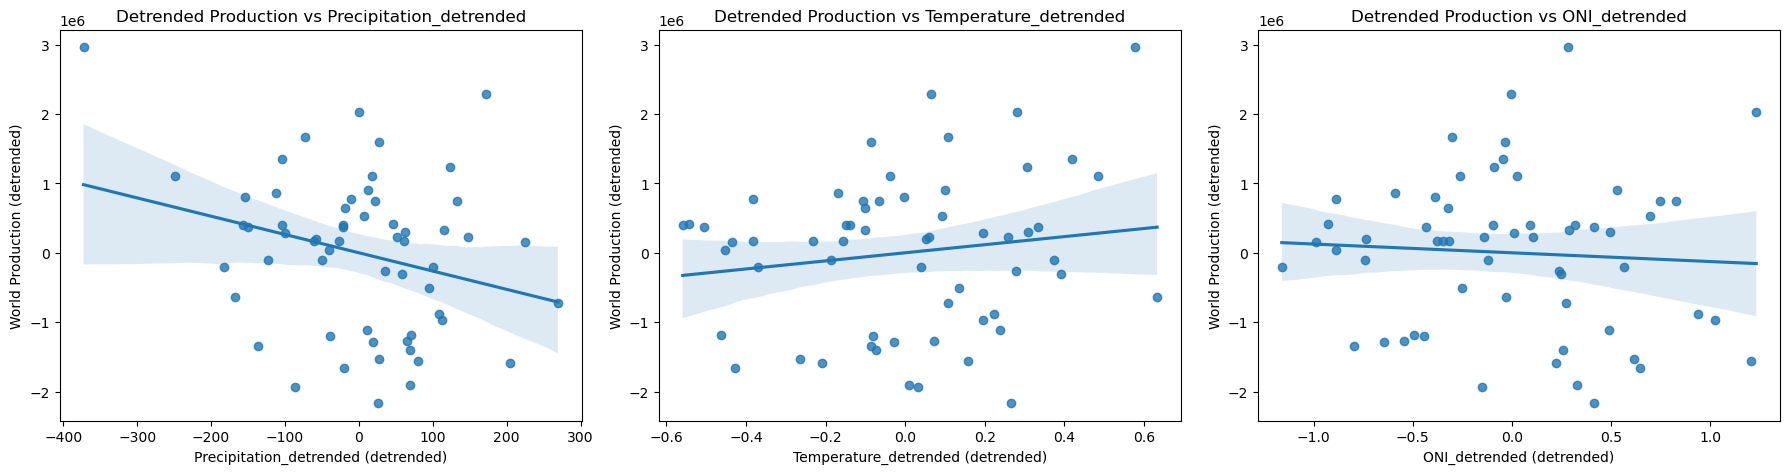

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, var in enumerate(['Precipitation_detrended', 'Temperature_detrended', 'ONI_detrended']):
    sns.regplot(x=var, y='World production_detrended', data=detrended_data, ax=axes[idx])
    axes[idx].set_title(f'Detrended Production vs {var}')
    axes[idx].set_xlabel(f'{var} (detrended)')
    axes[idx].set_ylabel('World Production (detrended)')

plt.tight_layout()
plt.show()

##### Summary and Interpretation of Detrended Regression Results:
After conducting detrending analysis, which removes common long-term trends from the variables, prevoious significant relationships largely disappear or weaken substantially. Specifically:

- Copper price, production, and consumption no longer show significant relationships with climate variables after detrending, suggesting that the previously observed associations were likely artifacts of shared long-term trends rather than genuine causal connections.

- Surprisingly, in the final detrended model including consumption and production, copper consumption becomes significantly negatively related to copper prices, a result that remains counterintuitive even after detrending.

Moreover, the continued negative relationship between copper consumption and copper prices after detrending is particularly intriguing. Intuitively, greater consumption should indicate higher .demand, typically raising prices. Yet, we observe the opposite. Possible interpretations can be:

- This could reflect short-term market adjustments or anticipatory behaviors. For instance, periods of high observed consumption might indicate markets expecting future price drops, causing downward pressure on prices despite immediate high consumption levels.

- Alternatively, consumption data might be capturing reactive demand rather than proactive demand—consumption increasing primarily when prices have already dropped, driven by market corrections rather than causing the price movements.

General Conclusion:
The detrending analysis importantly reveals that the initial significant relationships found in the raw regression models primarily stemmed from shared long-term trends (such as global economic growth or climatic shifts), rather than reflecting true explanatory relationships. Thus, the detrending step has proven essential to isolating meaningful short-term interactions.

#### Future Directions for More Convincing Results:
Given these findings, future analyses should consider:

- Time Lag Analysis:
Introduce lagged variables to capture delayed effects, as climate events or economic shifts likely influence markets over different time horizons rather than instantaneously.

- Regional Breakdown:
Climate impacts are highly region-specific. Incorporating regional copper production and consumption data might reveal nuanced relationships masked by global aggregation.

- Try Monthly Data:
In our current analysis, we relied solely on annual data due to time and data constraints. However, future research should utilize monthly-scale data because copper production and prices are likely more sensitive to seasonal weather patterns and short-term climatic fluctuations. A monthly approach would allow us to capture these detailed seasonal dynamics—such as disruptions from heavy rains or droughts—that annual data aggregation might obscure, thereby providing more precise and robust insights into copper market mechanisms.

- Enhanced Multicollinearity Management:
Applying statistical techniques like Ridge or Lasso regression to handle potential multicollinearity could yield more robust and interpretable results.

By following these directions, subsequent research will yield deeper and more reliable insights into how climatic and economic factors interactively influence global copper markets.